In [1]:
import pandas as pd
import os

os.chdir('..')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from transformers import AutoTokenizer
from src.predictors.contrastive import ContrastivePretrainModel, ContrastiveClassifierConfig
from src.utils import load_as_object
import torch

In [4]:
train_offers_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/pretrain-train.csv')
train_offers_df.head(10)

valid_offers_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/pretrain-valid.csv')
valid_offers_df.head(10)

train_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/train.csv')
valid_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/valid.csv')
test_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/test.csv')

,text,cluster_id
0,[COL] title [VAL] corsair cmu32gx4m4c3000c15 [...,279422
1,[COL] title [VAL] gigabyte gb bxbt 3000 brix p...,277774
2,[COL] title [VAL] seagate laptop sshd hybrid 2...,423211
3,[COL] title [VAL] buy online zotac gtx 1060 6g...,824793
4,[COL] title [VAL] apple 13 3 inch macbook pro ...,5114428
5,[COL] title [VAL] gigabyte radeon rx 580 gamin...,1324529
6,[COL] title [VAL] lenovo thinkpad work in case...,10641662
7,[COL] title [VAL] hp workstation z440 mt xeon ...,1464484
8,[COL] title [VAL] apple ipad pro 12 9 retina d...,1025712
9,[COL] title [VAL] intel core i5 4590 3 ghz pro...,129361


,text,cluster_id
0,"[COL] title [VAL] null , 238590 b21 hp 36 4 gb...",10952886
1,[COL] title [VAL] router wi fi ac750 cloud dir...,903353
2,[COL] title [VAL] micron 1100 solid state driv...,570789
3,[COL] title [VAL] 495605 b21 hp 64 gb 8x8gb pc...,13412888
4,[COL] title [VAL] msi amd am4 ryzen b350 tomah...,9092077
5,"[COL] title [VAL] null , 643772 b21 hp xeon e7...",119752
6,[COL] title [VAL] hp pl 8500r 2 xeon 550mhz 1m...,10713540
7,[COL] title [VAL] corsair vengeance led 16gb 2...,1044577
8,[COL] title [VAL] wd 120gb green sata 6gb s 2 ...,809618
9,[COL] title [VAL] startech displayport to hdmi...,1219171


In [5]:
# tokenizer(test_offers_df['text'].iloc[0]).tokens()

In [6]:
from typing import List


def encode_offer(value: str, tokenizer, bert, config) -> List[int]:
    tokens = tokenizer(value, return_tensors="pt", max_length=config.max_tokens, truncation=True)
    encoding = bert(tokens['input_ids'], attention_mask=tokens['attention_mask'])
    return encoding.last_hidden_state[0][0].tolist()

In [7]:
# with torch.no_grad():
#     test_offers_df['embedding'] = test_offers_df['text'].apply(encode_offer)

In [8]:
# with torch.no_grad():
#     result = encode_offer(test_offers_df['text'].iloc[0])
#     print(len(result))

In [9]:
import numpy as np

print(f'Installed numpy version {np.__version__}')

Installed numpy version 1.20.3


In [35]:
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def project2d(target: pd.DataFrame, tokenizer, model: ContrastivePretrainModel, config: ContrastiveClassifierConfig) -> pd.DataFrame:
    df = target.copy()
    with torch.no_grad():
        df['embedding'] = df['text'].apply(lambda v: encode_offer(v, tokenizer, model.transformer, config))

    embeddings_list = df['embedding'].tolist()
    embeddings = np.asarray(embeddings_list, dtype='float')
    scaler =  MinMaxScaler()
    features = scaler.fit_transform(embeddings)
    mapper = umap.UMAP(n_components=2, metric="cosine", random_state=42).fit(features) # TODO: fit once use it for all the epochs

    projection_df = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
    projection_df['X'] = scaler.fit_transform(projection_df[['X']])
    projection_df['Y'] = scaler.fit_transform(projection_df[['Y']])
    projection_df['label'] = df['cluster_id']
    return projection_df

In [11]:
import mplcursors
import matplotlib.pyplot as plt
%matplotlib notebook

In [12]:
from distinctipy import distinctipy

train_offers_df = pd.read_csv('data/processed/contrastive/wdc_computers_medium/pretrain-train.csv')
df_emb = train_offers_df.copy()
color_palette = distinctipy.get_colors(20)

df_labels = df_emb[['cluster_id']].drop_duplicates()
# color_repeat_count = len(df_labels) // len(color_palette) + 1
# color_palette = color_palette * color_repeat_count
# color_palette = color_palette[:len(df_labels)]
df_labels = df_labels.sample(n=20)
df_labels['color'] = color_palette

df_sampled_emb = df_emb.join(df_labels.set_index('cluster_id'), on='cluster_id', rsuffix='_c', how="right")
df_sampled_emb = df_sampled_emb.reset_index()
print(len(df_sampled_emb))

90


In [49]:
from src.predictors.contrastive import ContrastivePredictor
from src.preprocess.configs import ExperimentsArgumentParser

predictor = ContrastivePredictor(config_path='configs/model_train/contrastive/sampled/frozen_no-aug_batch-pt128_sample50_wdc-computers-medium.json')
predictor.config.unfreeze = False

arguments = ExperimentsArgumentParser()
arguments.parse_args("")
arguments.load_wandb_models = True
predictor.pretrain(train_offers_df, valid_offers_df, arguments=arguments, source_aware_sampling=False)
predictor.train(pd.DataFrame(), pd.DataFrame(), arguments=arguments)

checkpoint_model = ContrastivePretrainModel(transformer=predictor.trainer.model.transformer)
# cursor = mplcursors.cursor(sc, hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set_text(df_colored_emb['label'].loc[sel.index]))
# checkpoint_path = checkpoint.split('/')
# plt.savefig(os.path.join(figures_dir, f'{checkpoint_path[-1]}.png'))
# print(f'Saved {checkpoint_path[-1]}')


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D/resolve/main/config.json from cache at /home/robert/.cache/huggingface/transformers/740f3ffeb47194ea97e78563af6f51d8fce8d8346d36d41889c75780869cf609.71ad48e6ad371e0c3ffa4982a5cc1c97e41023678e120b71ebe50addd42ec567
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 3

ExperimentsArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

PyTorch: setting up devices
wandb: Downloading large artifact model-3r5jcj7l:v0, 54.78MB. 2 files... Done. 0:0:0
PyTorch: setting up devices


Successfully loaded model from path: ./artifacts/model-3r5jcj7l:v0/pytorch_model.bin


wandb: Downloading large artifact model-97ju0sgh:v0, 54.78MB. 2 files... Done. 0:0:0
loading configuration file https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D/resolve/main/config.json from cache at /home/robert/.cache/huggingface/transformers/740f3ffeb47194ea97e78563af6f51d8fce8d8346d36d41889c75780869cf609.71ad48e6ad371e0c3ffa4982a5cc1c97e41023678e120b71ebe50addd42ec567
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Successfully loaded model from path: ./artifacts/model-97ju0sgh:v0/pytorch_model.bin


In [50]:
from src.utils import seed_all
seed_all(42)

df_emb = project2d(df_sampled_emb, tokenizer=predictor.tokenizer, model=checkpoint_model, config=predictor.config)

<IPython.core.display.Javascript object>


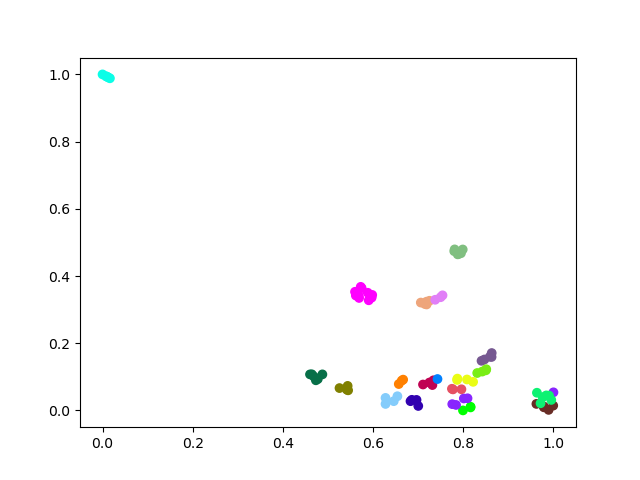

In [51]:
df_colored_emb = df_emb.set_index('label').join(df_labels.set_index('cluster_id'), rsuffix='_c')
df_colored_emb = df_colored_emb.reset_index().rename(columns={'index': 'label'})

fig, ax = plt.subplots()
sc = ax.scatter(df_colored_emb['X'], df_colored_emb['Y'], c=df_colored_emb['color'])

In [27]:
# import glob
#
# checkpoints = glob.glob("output/contrastive_frozen_wdc-computers-medium/pretrain/checkpoint-[0-9]*")
# checkpoints = sorted(checkpoints, key=lambda x: int(x.split('/')[-1].split('-')[-1]))
#
# config: ContrastiveClassifierConfig = load_as_object(
#     "configs/model_train/contrastive/frozen_no-aug_wdc-computers-medium.json",
#     ContrastiveClassifierConfig.parse_obj)
# pretrained_tokenizer = AutoTokenizer.from_pretrained(config.transformer_name,
#                                                      additional_special_tokens=('[COL]', '[VAL]'))
#
# figures_dir = os.path.join('output', 'figures', 'contrastive_frozen_wdc-computers-medium')
# if not os.path.exists(figures_dir):
#     os.makedirs(figures_dir)
#
# for checkpoint in checkpoints:
#     checkpoint_model = ContrastivePretrainModel(len_tokenizer=len(pretrained_tokenizer), model=config.transformer_name)
#
#     model_state = torch.load(os.path.join(checkpoint, 'pytorch_model.bin'))
#     checkpoint_model.load_state_dict(model_state)
#     checkpoint_model.to(torch.device('cpu'))
#
#
#     df_emb = project2d(df_sampled_emb, tokenizer=pretrained_tokenizer, model=checkpoint_model)
#     df_colored_emb = df_emb.set_index('label').join(df_labels.set_index('cluster_id'), rsuffix='_c')
#     df_colored_emb = df_colored_emb.reset_index().rename(columns={'index': 'label'})
#
#     fig, ax = plt.subplots()
#     sc = ax.scatter(df_colored_emb['X'], df_colored_emb['Y'], c=df_colored_emb['color'])
#     # cursor = mplcursors.cursor(sc, hover=True)
#     # cursor.connect("add", lambda sel: sel.annotation.set_text(df_colored_emb['label'].loc[sel.index]))
#     checkpoint_path = checkpoint.split('/')
#     plt.savefig(os.path.join(figures_dir, f'{checkpoint_path[-1]}.png'))
#     print(f'Saved {checkpoint_path[-1]}')


In [11]:
from PIL import Image

figures_dir = os.path.join('output', 'figures', 'contrastive_frozen_wdc-computers-medium')
frame_paths = glob.glob(os.path.join(figures_dir, '*.png'))
frame_paths = sorted(frame_paths, key=lambda x: int(x.split('/')[-1].split('.')[0].split('-')[-1]))

frames = [Image.open(i) for i in frame_paths]
frames[0].save(os.path.join(figures_dir, 'all.gif'), format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

In [13]:
from src.predictors.contrastive import ContrastivePredictor
from src.preprocess.configs import ExperimentsArgumentParser

unfrozen_predictor = ContrastivePredictor(config_path='configs/model_train/contrastive/unfrozen_no-aug_batch-pt128_wdc-computers-medium.json')
frozen_predictor = ContrastivePredictor(config_path='configs/model_train/contrastive/frozen_no-aug_batch-pt128_wdc-computers-medium.json')

arguments = ExperimentsArgumentParser()
arguments.parse_args("")
arguments.load_wandb_models = True
# unfrozen_predictor.pretrain(train_offers_df, valid_offers_df, arguments=arguments, source_aware_sampling=False)
unfrozen_predictor.train(pd.DataFrame(), pd.DataFrame(), arguments=arguments)
frozen_predictor.train(pd.DataFrame(), pd.DataFrame(), arguments=arguments)

unfrozen_f1 = unfrozen_predictor.test(test_df)
frozen_f1 = frozen_predictor.test(test_df)

print(f"{unfrozen_f1}, {frozen_f1}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.1.weight', 'fit_denses.4.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'fit_denses.3.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'fit_denses.0.weight', 'fit_denses.4.bias', 'fit_denses.0.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'fit_denses.2.bias', 'fit_denses.2.weight', 'fit_denses.1.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architect

ExperimentsArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

wandb: Downloading large artifact model-3rfzmkeh:v0, 54.78MB. 2 files... Done. 0:0:0
loading configuration file https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D/resolve/main/config.json from cache at /home/robert/.cache/huggingface/transformers/740f3ffeb47194ea97e78563af6f51d8fce8d8346d36d41889c75780869cf609.71ad48e6ad371e0c3ffa4982a5cc1c97e41023678e120b71ebe50addd42ec567
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Successfully loaded model from path: ./artifacts/model-3rfzmkeh:v0/pytorch_model.bin


wandb: Downloading large artifact model-wm5888ah:v0, 54.78MB. 2 files... Done. 0:0:0
loading configuration file https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D/resolve/main/config.json from cache at /home/robert/.cache/huggingface/transformers/740f3ffeb47194ea97e78563af6f51d8fce8d8346d36d41889c75780869cf609.71ad48e6ad371e0c3ffa4982a5cc1c97e41023678e120b71ebe50addd42ec567
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Successfully loaded model from path: ./artifacts/model-wm5888ah:v0/pytorch_model.bin


***** Running Prediction *****
  Num examples = 1100
  Batch size = 8


0.6985507246376812, 0.9765100671140939
